# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df.shape

(50000, 14)

In [9]:
trip_count = df['booking_complete'].value_counts()
print(trip_count)

0    42522
1     7478
Name: booking_complete, dtype: int64


<AxesSubplot: ylabel='booking_complete'>

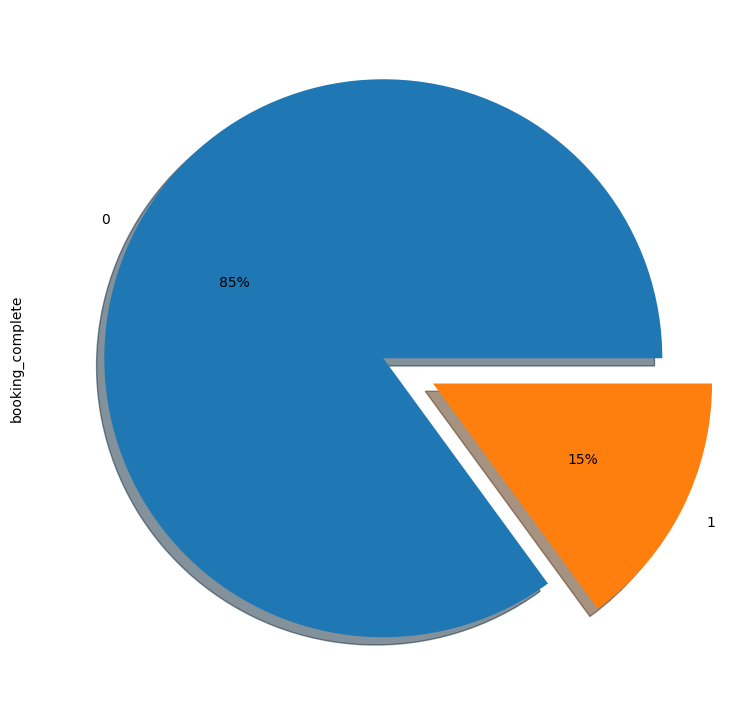

In [10]:
trip_count.plot.pie(autopct = '%.0f%%', explode = [0, 0.2], shadow = True, figsize = (9, 10))

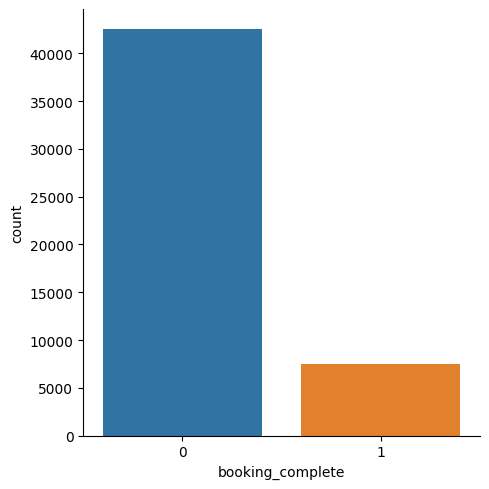

In [11]:
sns.catplot(x = 'booking_complete', data = df, kind = 'count')

In [12]:
booking_by_day = df.groupby('flight_day')['booking_complete'].value_counts()
print(booking_by_day)

flight_day  booking_complete
1           0                   6898
            1                   1204
2           0                   6544
            1                   1129
3           0                   6422
            1                   1252
4           0                   6302
            1                   1122
5           0                   5778
            1                    983
6           0                   4951
            1                    861
7           0                   5627
            1                    927
Name: booking_complete, dtype: int64


In [13]:
booking_by_hour = df.groupby('flight_hour')['booking_complete'].value_counts()
print(booking_by_hour)

flight_hour  booking_complete
0            0                   1357
             1                    182
1            0                   1804
             1                    285
2            0                   2253
             1                    389
3            0                   2262
             1                    393
4            0                   2413
             1                    430
5            0                   2420
             1                    431
6            0                   2562
             1                    488
7            0                   2703
             1                    423
8            0                   2681
             1                    484
9            0                   2624
             1                    508
10           0                   2670
             1                    415
11           0                   2703
             1                    407
12           0                   2703
             1      

In [14]:
booking_by_seat = df.groupby('wants_preferred_seat')['booking_complete'].value_counts()
print(booking_by_seat)

wants_preferred_seat  booking_complete
0                     0                   30303
                      1                    4849
1                     0                   12219
                      1                    2629
Name: booking_complete, dtype: int64


<AxesSubplot: ylabel='booking_complete'>

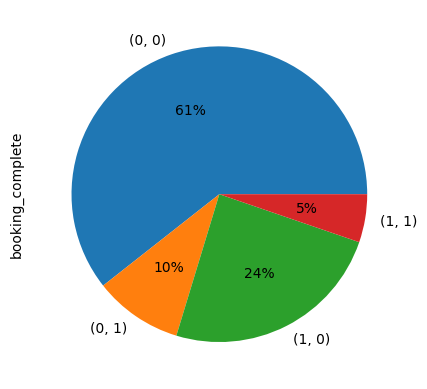

In [15]:
booking_by_seat.plot.pie(autopct = '%.0f%%')

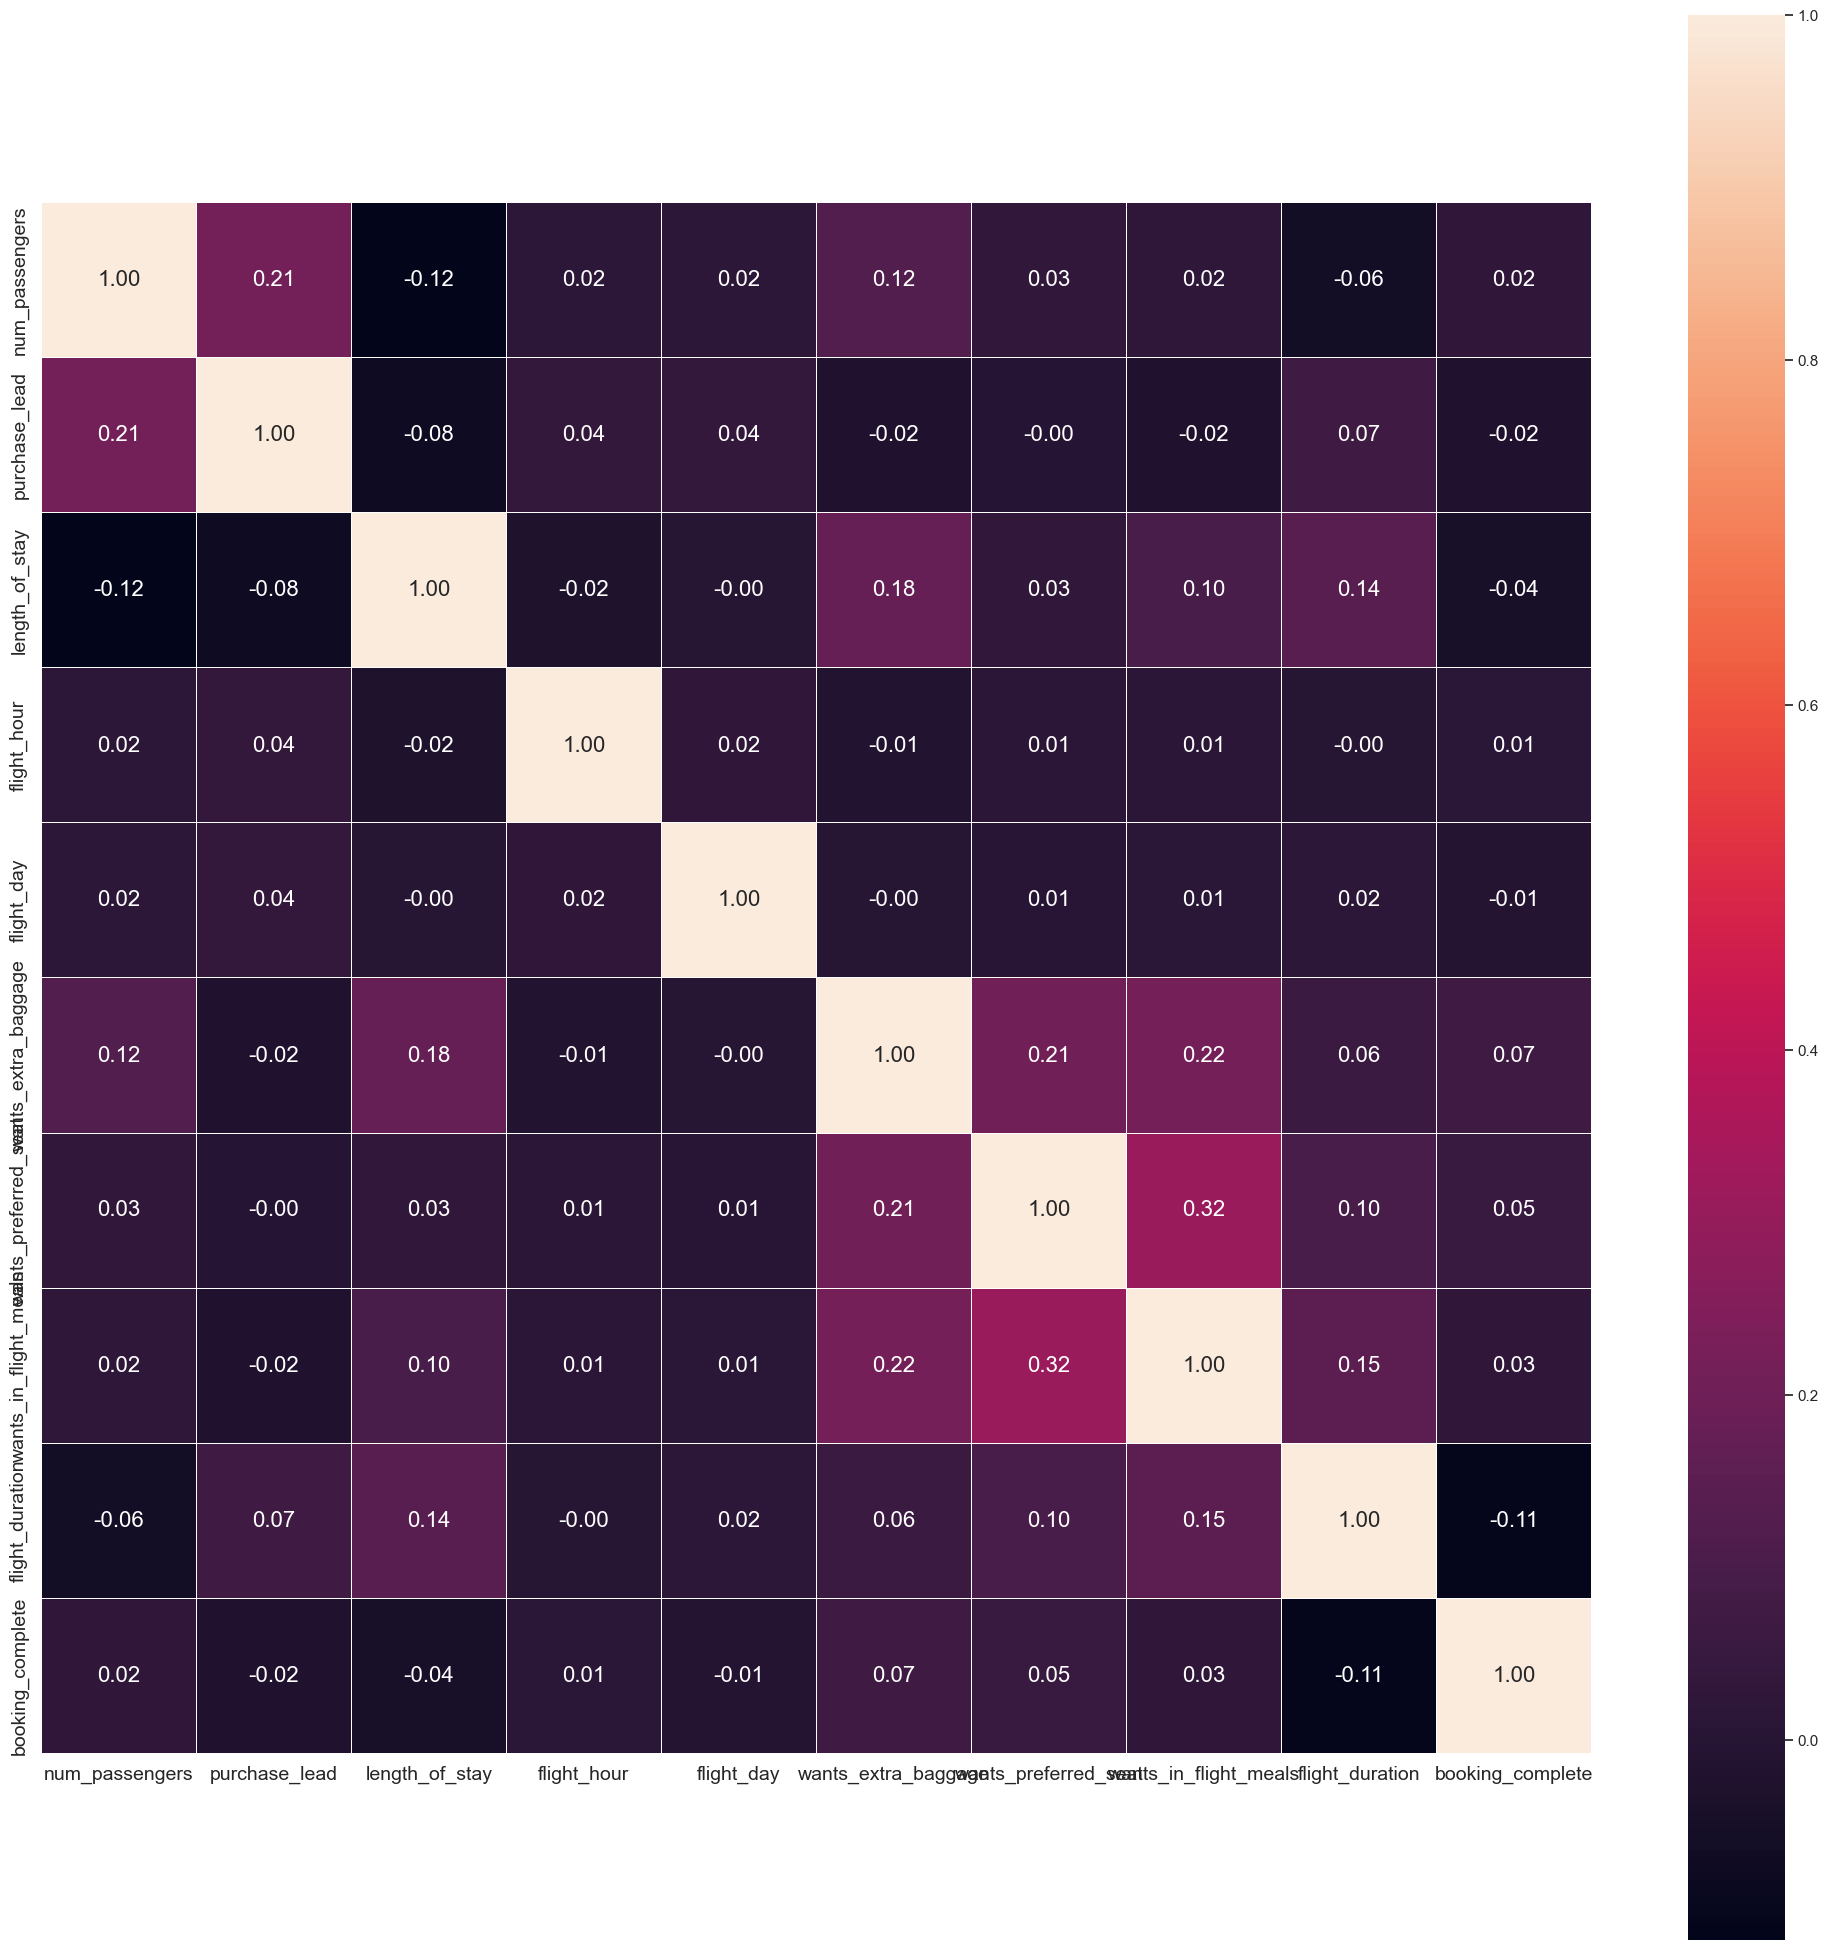

In [16]:
sns.set()
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(df.corr(), annot = True, square = True, fmt = '.2f', annot_kws = {"size" : 16}, linewidths = 0.5)
ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)

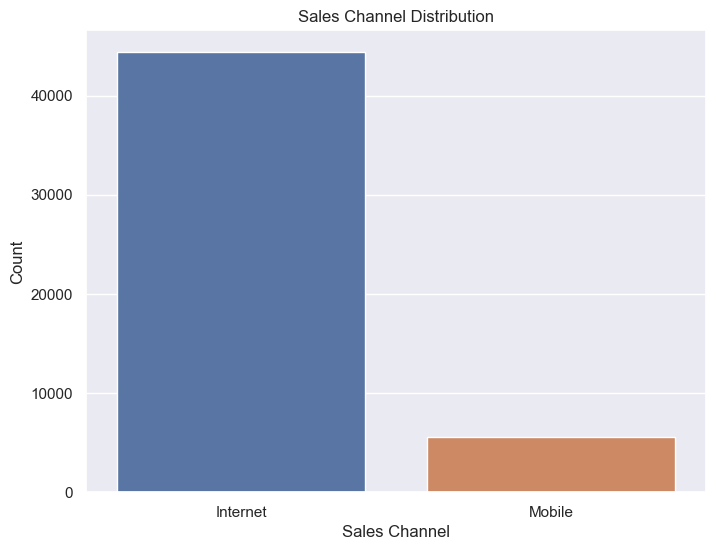

In [17]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'sales_channel', data = df)
plt.title('Sales Channel Distribution')
plt.xlabel('Sales Channel')
plt.ylabel('Count')
plt.show()

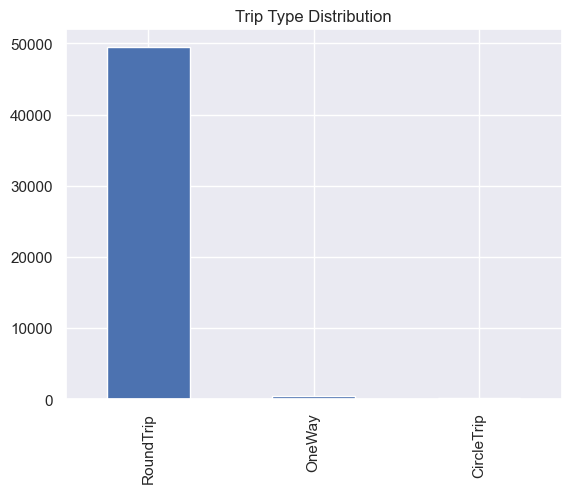

In [18]:
df['trip_type'].value_counts().plot(kind = 'bar')
plt.title('Trip Type Distribution')
plt.ylabel('')
plt.show()

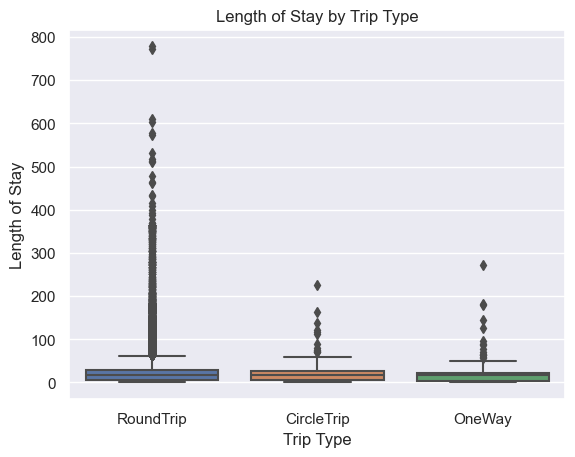

In [19]:
sns.boxplot(x = 'trip_type', y = 'length_of_stay', data = df)
plt.title('Length of Stay by Trip Type')
plt.xlabel('Trip Type')
plt.ylabel('Length of Stay')
plt.show()

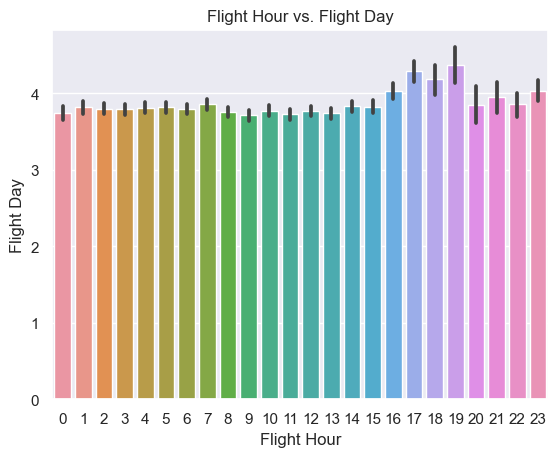

In [20]:
sns.barplot(x = 'flight_hour', y = 'flight_day', data = df)
plt.title('Flight Hour vs. Flight Day')
plt.xlabel('Flight Hour')
plt.ylabel('Flight Day')
plt.show()

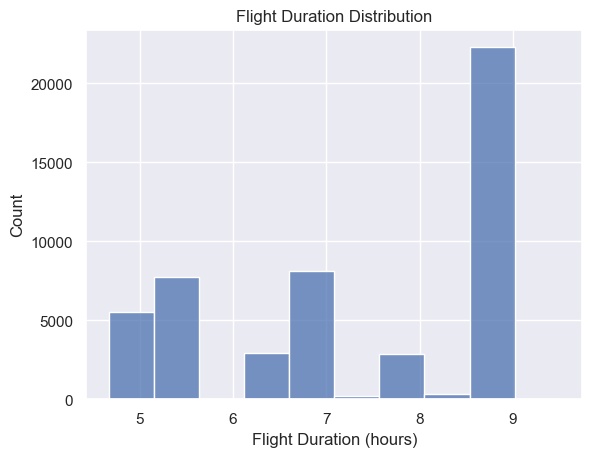

In [21]:
sns.histplot(df['flight_duration'], bins = 10)
plt.title('Flight Duration Distribution')
plt.xlabel('Flight Duration (hours)')
plt.ylabel('Count')
plt.show()

In [22]:
df['flight_time_category'] = pd.cut(df['flight_hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
df['weekend_flight'] = df['flight_day'].apply(lambda x: 1 if x >= 5 else 0)

In [23]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_time_category,weekend_flight
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,Morning,1
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,Night,1
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,Afternoon,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,Night,1
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,Afternoon,0


In [24]:
X = pd.get_dummies(df.drop('booking_complete', axis=1), drop_first = True)
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 21)

In [25]:
rf = RandomForestClassifier(n_estimators = 250, random_state = 21)
rf.fit(X_train, y_train)
importance = rf.feature_importances_
top_10_features = X_train.columns[np.argsort(importance)][::-1][:10]

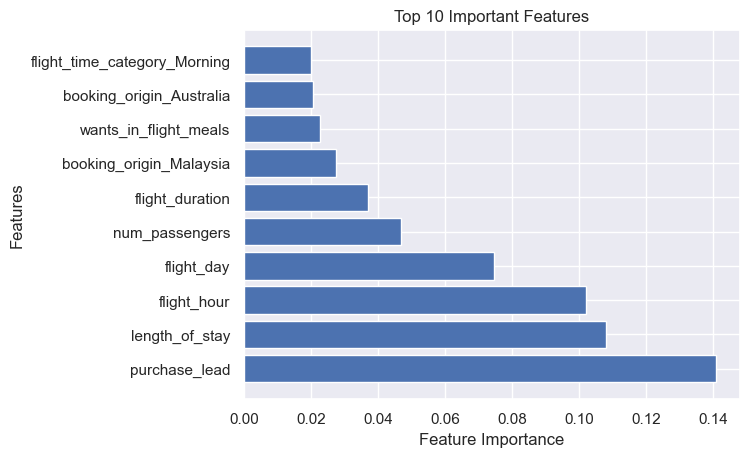

In [26]:
plt.barh(top_10_features, importance[np.argsort(importance)][::-1][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()

In [27]:
y_pred = rf.predict(X_test)

In [28]:
cv_scores = cross_val_score(rf, X_train, y_train, cv = 5)

In [29]:
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")

Mean Accuracy: 0.850125
Standard Deviation of Accuracy: 0.0008023403267940553


In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8508


In [31]:
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[8324  162]
 [1330  184]]


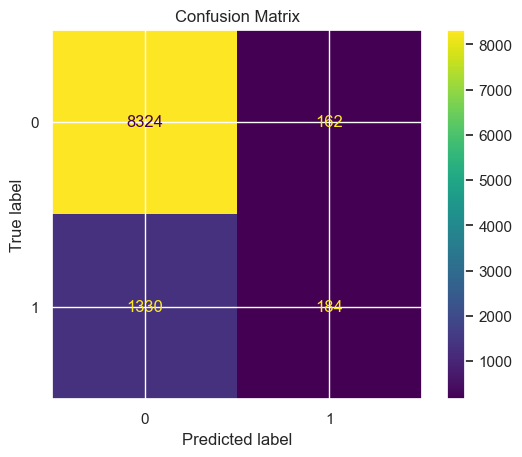

In [32]:
confusion_display = ConfusionMatrixDisplay(confusion_matrix = confusion)
confusion_display.plot()
plt.title('Confusion Matrix')
plt.show()

In [33]:
print('Cross Validation Scores:', cv_scores)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion)

Cross Validation Scores: [0.851625 0.850125 0.84925  0.849875 0.84975 ]
Accuracy: 0.8508
Confusion Matrix:
 [[8324  162]
 [1330  184]]


In [34]:


dtrain = xgb.DMatrix(X_train[top_10_features], label = y_train)
dtest = xgb.DMatrix(X_test[top_10_features])

In [35]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train[top_10_features], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [36]:
y_pred_xgb = xgb_model.predict(X_test[top_10_features])

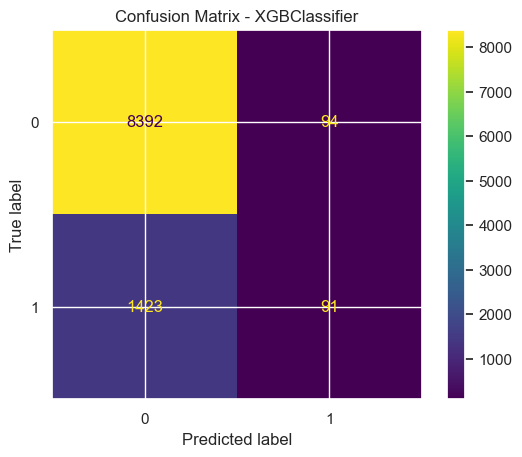

In [37]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)
confusion_display_xgb = ConfusionMatrixDisplay(confusion_matrix = confusion_xgb)
confusion_display_xgb.plot()
plt.title('Confusion Matrix - XGBClassifier')
plt.show()

In [38]:
print('Accuracy - XGBClassifier:', accuracy_xgb)
print('Confusion Matrix - XGBClassifier:\n', confusion_xgb)

Accuracy - XGBClassifier: 0.8483
Confusion Matrix - XGBClassifier:
 [[8392   94]
 [1423   91]]
